In [1]:
%run init_notebookspace.py
from settings import *

## Table of Content
* [Make RBC Model](#chapter1)
    * [Model Equations](#section_1_1)
    * [Find Steady State, Solve the Model](#section_1_2)
* [Get Italy data](#chapter2)
* [Preprocessing the data](#chapter3)
    * [Log-Transforming of the Data](#section_3_1)
    * [Detrending the Data](#section_3_2)
    * [Detrending the Data](#section_3_3)
* [Maximum Likelihood Estimation](#chapter4)
    * [MLE Kalman Filter Prediction](#section_4_1)
    * [Kalman Smoother output](#section_4_2)
    * [Impulse response](#section_4_3)

In [2]:
%matplotlib inline
import gEcon as ge
import gEcon.plotting as gp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import arviz as az

import os
import statsmodels.api as sm
import statsmodels
import scipy

from src.utils import time_format, plot_df, get_seasonal_hp, arr_adf, apply_func, poly_detrend

# from TimeSeriesTools.stats import ADF_test_summary
# from TimeSeriesTools.transformers import DetrendTransformer, LogTransformer

config = {
    'figure.figsize':(14,4),
    'figure.dpi':144,
    'figure.facecolor':'white',
    'axes.grid':True,
    'grid.linestyle':'--',
    'grid.linewidth':0.5,
    'axes.spines.top':False,
    'axes.spines.bottom':False,
    'axes.spines.left':False,
    'axes.spines.right':False
}

plt.rcParams.update(config)

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Get Italy data <a class="anchor" id="chapter2"></a>

We want series for consumption, investment, labor, GDP, interest rate, and wages

In [3]:
data = pd.read_csv(os.path.join(DATA_DIR, "all_rbc_data.csv"), infer_datetime_format="QS")
data["TIME"] = time_format(data.TIME)
data.set_index("TIME", drop=True, inplace=True)
data.sort_index(inplace=True)

data.rename(columns=dict(zip(data.columns, ["Y", "I", "Z", "X", "r", "C", "w", "L"])), inplace=True)

data.drop(["X", "Z"], axis=1, inplace=True)

## Prepocessing the Data <a class="anchor" id="chapter3"></a>

In [4]:
# check for na
print("NaNs \n", data.isna().sum())
df = data.copy()

NaNs 
 Y     0
I     0
r     0
C     0
w    36
L     0
dtype: int64


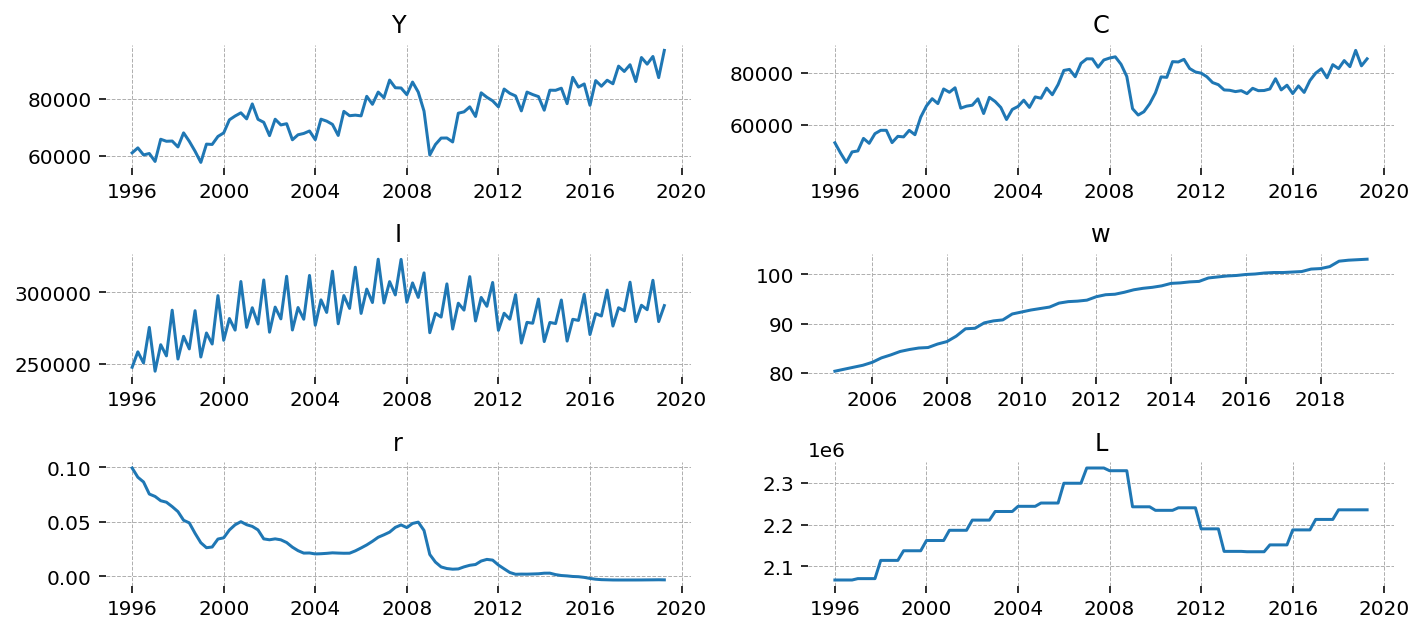

In [5]:
# raw data
plot_df(data)

### Log-transformation <a class="anchor" id="section_3_1"></a>

In [6]:
# log transform
for col in [item for item in df.columns if item != "r"]:
    df[col] = apply_func(df[col], func=np.log)

Raw data is log transformed, thus somehow equalised in scale

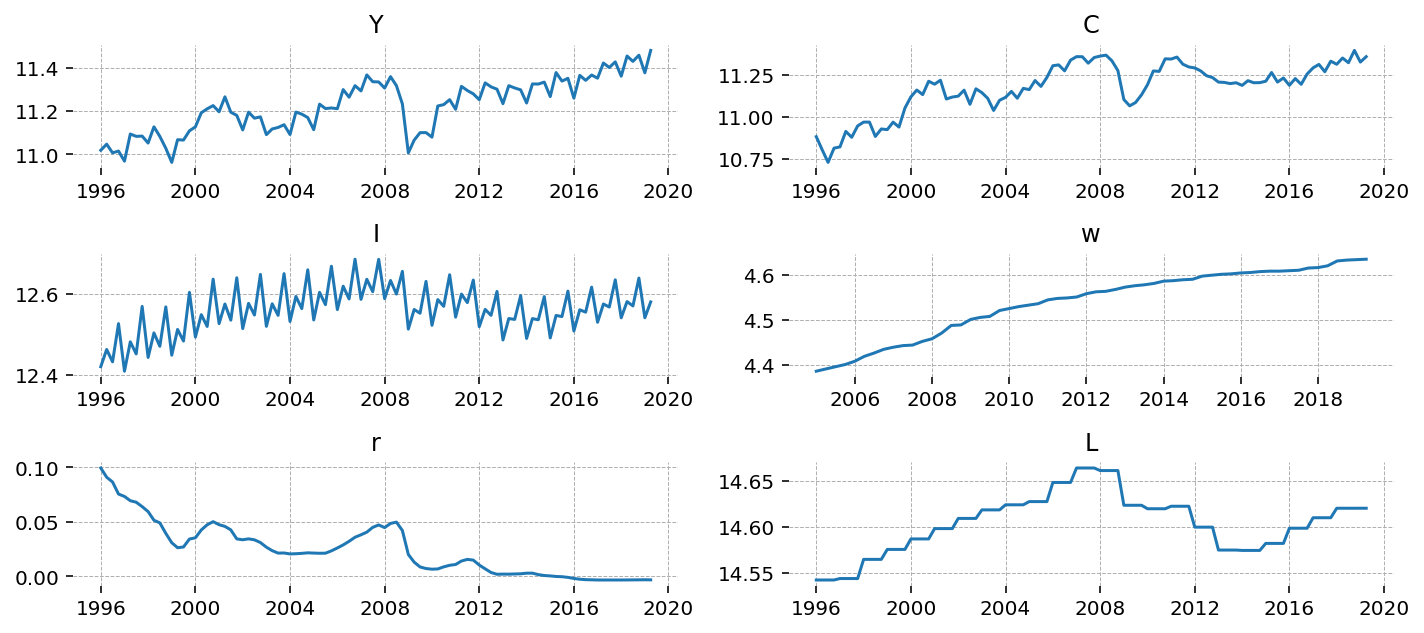

In [7]:
plot_df(df)

### Detrend the Data <a class="anchor" id="section_3_3"></a>

The HP filter identified the underlying trend. Yet the trend is by nature non-stationary, thus not suitable to most statistical procedures. For detrending we use a 2nd order polynomial detrender.

[nan nan]


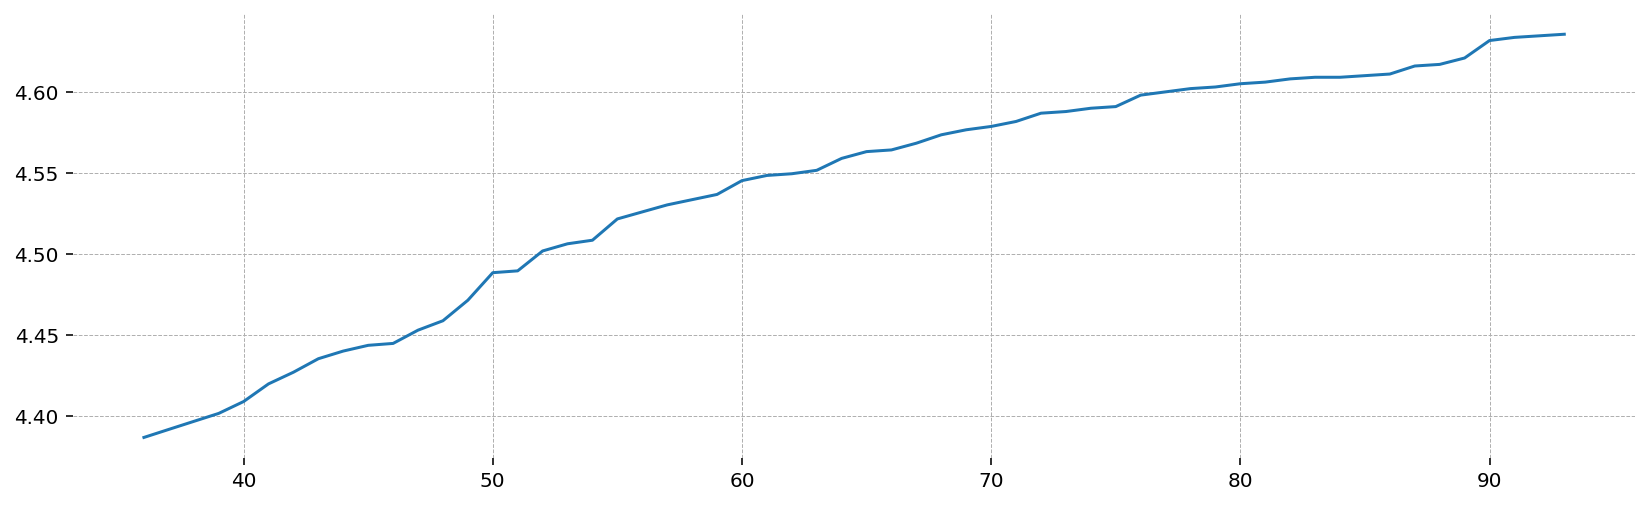

In [8]:
arr = df.w.copy()
arrx = range(0, len(arr))
model = np.polyfit(arrx, arr.values, 1)
print(model)

plt.plot(arr.values)
plt.plot(np.polyval(model, arrx))

In [9]:
mask = df.copy()
for col in df:
    df[col] = poly_detrend(df[col], poly_order=2, skipna=True)
    mask[col] = poly_detrend(df[col], poly_order=2, skipna=True, return_pred=True)

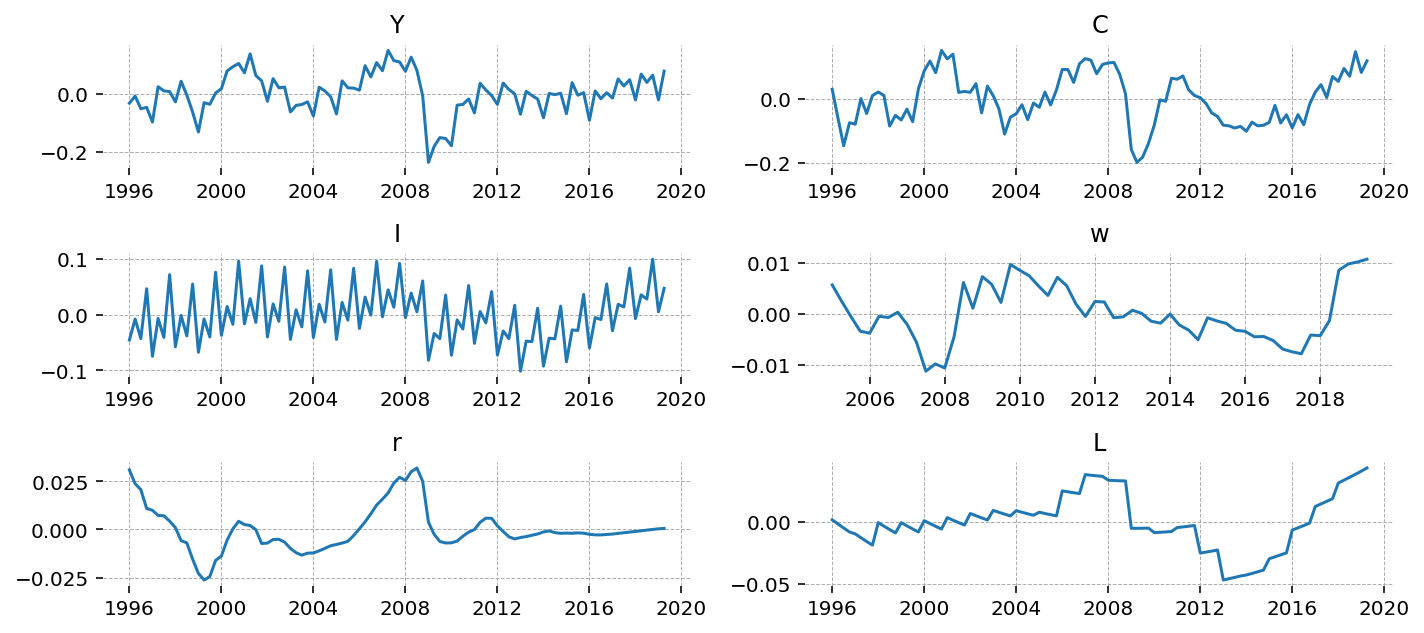

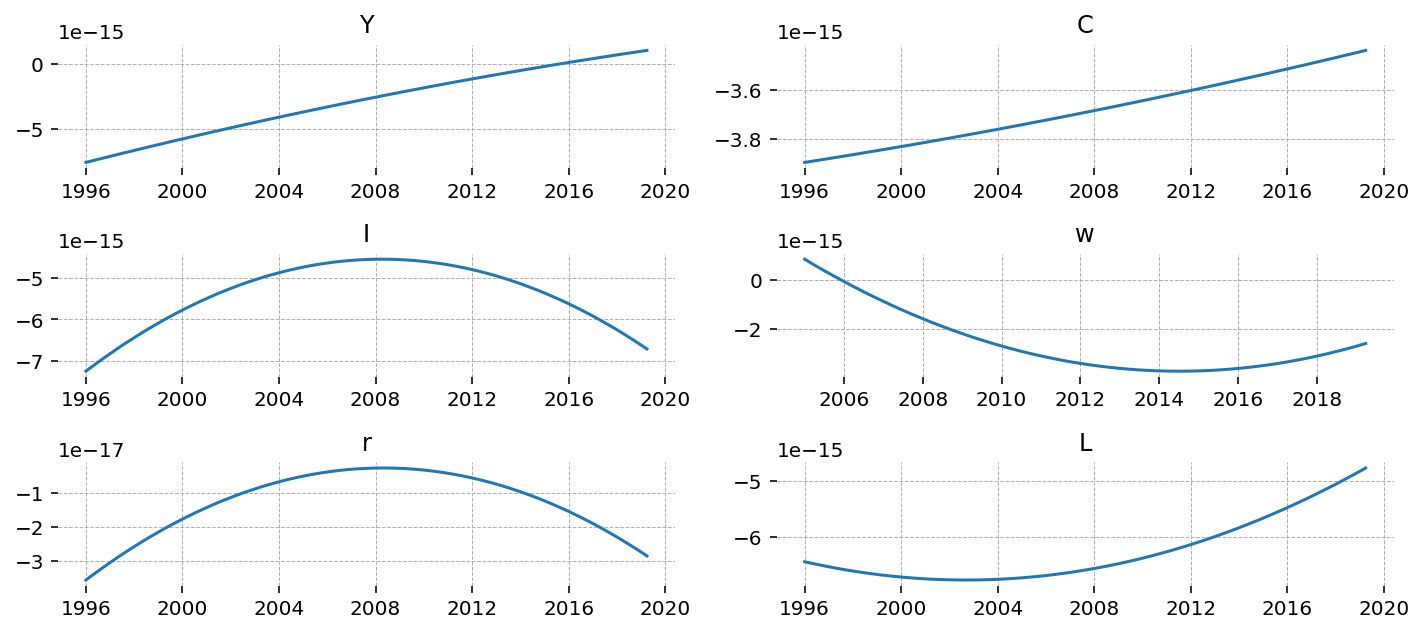

In [10]:
plot_df(df)
plot_df(mask)

### Deseasonalise the Data <a class="anchor" id="section_3_2"></a>

In [11]:
desea_cols = ['Y', 'I', 'C', 'w', 'L'] # r not seasonal
for col in desea_cols:
    df[col] = get_seasonal_hp(df[col], lamb=6.25, skipna=True, )

For deseasonalisation we chose the Hodrick-Prescott filter, which identifies the underlying trend

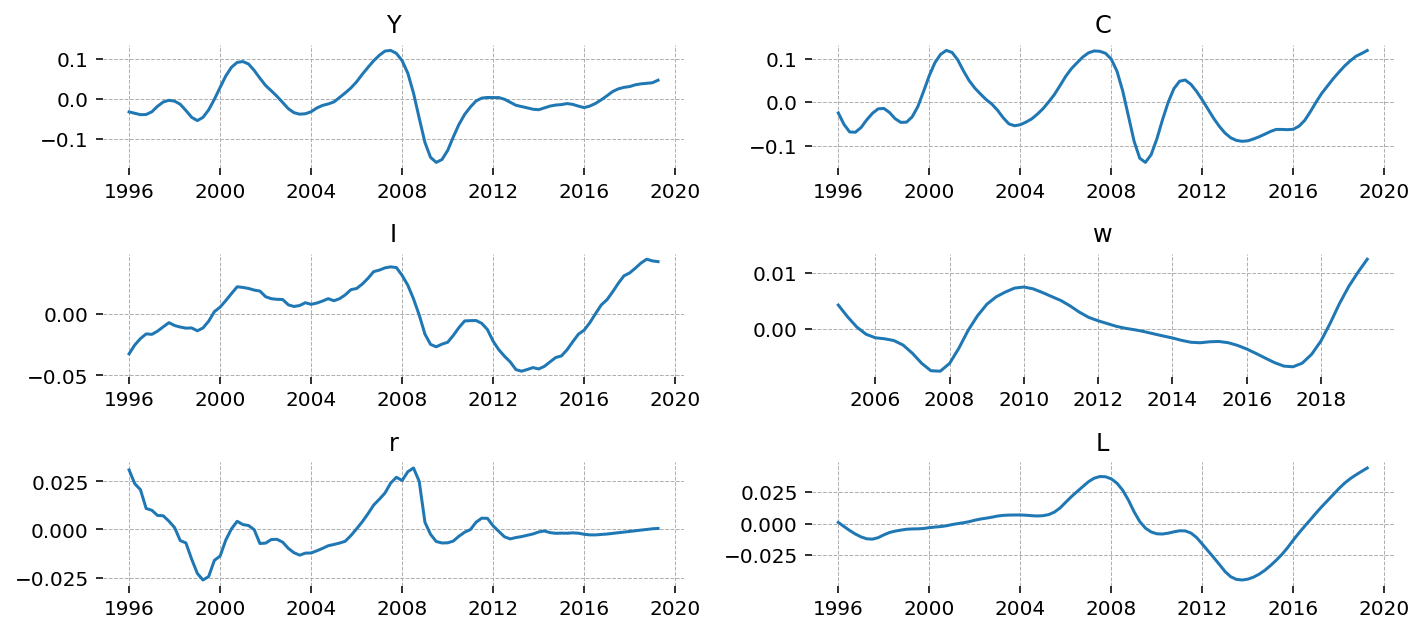

In [12]:
plot_df(df)

### Check stationarity after tranformation <a class="anchor" id="section_3_3"></a>

In [13]:
for col in df.columns:
    arr_adf(df[col], skipna=True, p_level=.1)

Y  p-val: 0.06199375150416608,  reject: True
I  p-val: 0.08810746779728951,  reject: True
r  p-val: 0.00887241125533289,  reject: True
C  p-val: 0.13465399259285532,  reject: False
w  p-val: 0.079272347620638,  reject: True
L  p-val: 0.03702931818509586,  reject: True


# Make RBC Model <a class="anchor" id="chapter1"></a>

In [32]:
rbc = ge.gEconModel(os.path.join(DATA_DIR, 'rbc.gnc'))

Model Building Complete.
Found:
	9 equations
	9 variables
	The following variables were eliminated at user request:
		TC_t,U_t
	The following "variables" were defined as constants and have been substituted away:
		mc_t
	1 stochastic shock
		 1 / 1 have a defined prior. 
	6 parameters
		 4 / 6 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



## Model Equations  c

In [33]:
for equation in rbc.system_equations:
    display(equation)

-C_t - I_t + K_t-1*r_t + L_t*w_t

I_t - K_t + K_t-1*(1 - delta)

-lambda_t + C_t**(-sigma_C)

-L_t**sigma_L + lambda_t*w_t

beta*(lambda_t+1*r_t+1 - lambda_t+1*(delta - 1)) - lambda_t

A_t*K_t-1**alpha*L_t**(1 - alpha) - Y_t

alpha*A_t*K_t-1**(alpha - 1)*L_t**(1 - alpha) - r_t

A_t*K_t-1**alpha*(1 - alpha)/L_t**alpha - w_t

rho_A*log(A_t-1) + epsilon_A_t - log(A_t)

## Find Steady State, Solve the Model <a class="anchor" id="section_1_2"></a>

In [34]:
rbc.steady_state()
rbc.solve_model()

Steady state found! Sum of squared residuals is 5.05225966748797e-27
Solution found, sum of squared residuals:  6.815161490367271e-28
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


In [35]:
rbc.print_steady_state()

A_ss               1.000
C_ss              11.649
I_ss               4.026
K_ss             402.632
L_ss               4.952
Y_ss              15.675
lambda_ss          0.983
r_ss               0.010
w_ss               2.336


## Check Blanchard Kahn Conditions

In [36]:
rbc.check_bk_condition()

Model solution has 2 eigenvalues greater than one in modulus and 2 forward-looking variables.
Blanchard-Kahn condition is satisfied.


,Modulus,Real,Imaginary
0,6.736812e-31,-6.736812e-31,-0.0
1,2.239773e-19,2.239773e-19,0.0
2,1.319356e-17,1.319356e-17,0.0
3,2.817686e-17,2.817686e-17,0.0
4,3.407138e-17,3.407138e-17,0.0
5,8.642163e-01,8.642163e-01,0.0
6,9.500000e-01,9.500000e-01,0.0
7,1.157349e+00,1.157349e+00,0.0
8,2.400315e+06,2.400315e+06,0.0


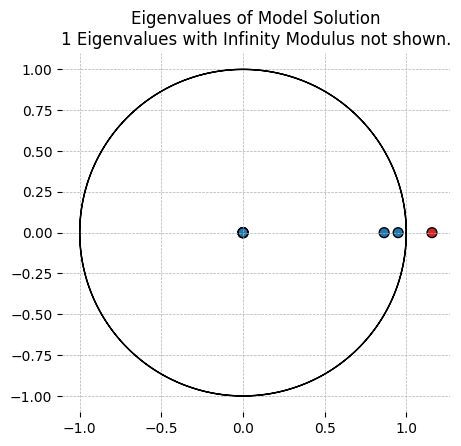

In [37]:
gp.plot_eigenvalues(rbc);

# Maximum Likelihood Estimation <a class="anchor" id="chapter4"></a>

In [38]:
# assign date freq
df = df.asfreq("QS")
df.head()

,Y,I,r,C,w,L
TIME,,,,,,
1996-01-01,-0.032228,-0.032402,0.031027,-0.024573,NaN,0.000863
1996-04-01,-0.035619,-0.025153,0.023845,-0.050817,NaN,-0.002345
1996-07-01,-0.039140,-0.019975,0.020751,-0.068148,NaN,-0.005451
1996-10-01,-0.038587,-0.016126,0.010947,-0.068910,NaN,-0.008264
1997-01-01,-0.031844,-0.016498,0.009998,-0.057862,NaN,-0.010531


In [39]:
MLEModel = ge.compile_to_statsmodels(rbc)

In [40]:
calibrated_params = {'beta':0.9998, 'alpha':0.262, 'sigma_L':0.52,'sigma_C': 0.0068, 'delta':0.01, 'rho_A': 0.9405}
rbc.free_param_dict.update(calibrated_params)

In [41]:
from gEcon.classes.transformers import PositiveTransformer, IntervalTransformer

# NOTE: We have to change this parameters probably

param_start_dict = {'sigma_C':1.5, 
                    'sigma_L':2.0,
#                     'alpha':0.5,
                    'rho_A':0.85}

shock_start_dict = {
    'epsilon_A':0.5
}

noise_start_dict = {
#     'Y':0.01,
    'C':0.02,
    'L':0.05,
    'I':0.02,
    'r':0.03,
    'w':0.1
}

# The slope parameter controls the steepness of the gradient around 0 (lower slope = more gentle gradient)
param_transforms = {
    'sigma_C': IntervalTransformer(low=1.05, high=10.0, slope=1),
    'sigma_L': IntervalTransformer(low=1.05, high=10.0, slope=1),
    'rho_A':IntervalTransformer(low=1e-4, high=0.99, slope=1),
#     'alpha':IntervalTransformer(low=0.1, high=0.80, slope=1)
}

mle_mod = MLEModel(df,
               param_start_dict = param_start_dict,
               shock_start_dict = shock_start_dict,
               noise_start_dict = noise_start_dict,
               param_transforms = param_transforms,
               shock_transforms=None, # If None, will automatically transform to positive values only
               noise_transforms=None, # If None, will automatically transform to positive values only
               initialization='stationary')

In [42]:
mle_res = mle_mod.fit(method='nm', maxiter=10_000)
mle_res = mle_mod.fit(method='lbfgs', maxiter=1_000, start_params=mle_res.params)

Optimization terminated successfully.
         Current function value: -8.781067
         Iterations: 1253
         Function evaluations: 1953


In [43]:
mle_res.summary()

C:\Users\LukasGrahl\Documents\GIT\macro_rbc\env_macro_rbc\lib\site-packages\statsmodels\tsa\stattools.py:1346: RuntimeWarning: divide by zero encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:     ['Y', 'I', 'r', 'C', 'w', 'L']   No. Observations:                   94
Model:                                  DSGEModel   Log Likelihood                 284.854
Date:                            Mon, 05 Dec 2022   AIC                           -551.709
Time:                                    15:47:31   BIC                           -528.819
Sample:                                01-01-1996   HQIC                          -542.463
                                     - 04-01-2019                                         
Covariance Type:                              opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma_C              1.0500     31.376      0.033      0.973     -60.446      62.546
sigma_L             10.0000    657.952      0.015      0.988   -1279.562    1299.562
rho_A                0.9900      0.145      6.806      0.000       0.705       1.275
sigma2.epsilon_A     0.0197      0.150      0.131      0.895      -0.275       0.314
sigma2.C             0.1961      1.839      0.107      0.915      -3.409       3.801
sigma2.L             0.0547      0.832      0.066      0.948      -1.577       1.686
sigma2.I             0.0668      0.734      0.091      0.927      -1.371       1.505
sigma2.r             0.0592      0.039      1.515      0.130      -0.017       0.136
sigma2.w             0.0199      0.297      0.067      0.947      -0.562       0.601
=============================================================================================================================
Ljung-Box (L1) (Q):     79.80, 87.57, 89.15, 85.83, 88.16, 90.54   Jarque-Bera (JB):   71.78, 24.01, 42.26, 4.18, 43.62, 0.86
Prob(Q):                      0.00, 0.00, 0.00, 0.00, 0.00, 0.00   Prob(JB):               0.00, 0.00, 0.00, 0.12, 0.00, 0.65
Heteroskedasticity (H):       0.12, 0.12, 0.22, 2.44, inf, 17.11   Skew:                 -1.29, 0.78, 1.17, 0.12, 0.55, -0.21
Prob(H) (two-sided):          0.00, 0.00, 0.00, 0.02, 0.00, 0.00   Kurtosis:               6.42, 4.93, 5.31, 1.99, 6.15, 2.78
=============================================================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (centered finite differences).
"""

## MLE Kalman Filter Prediction <a class="anchor" id="section_4_1"></a>

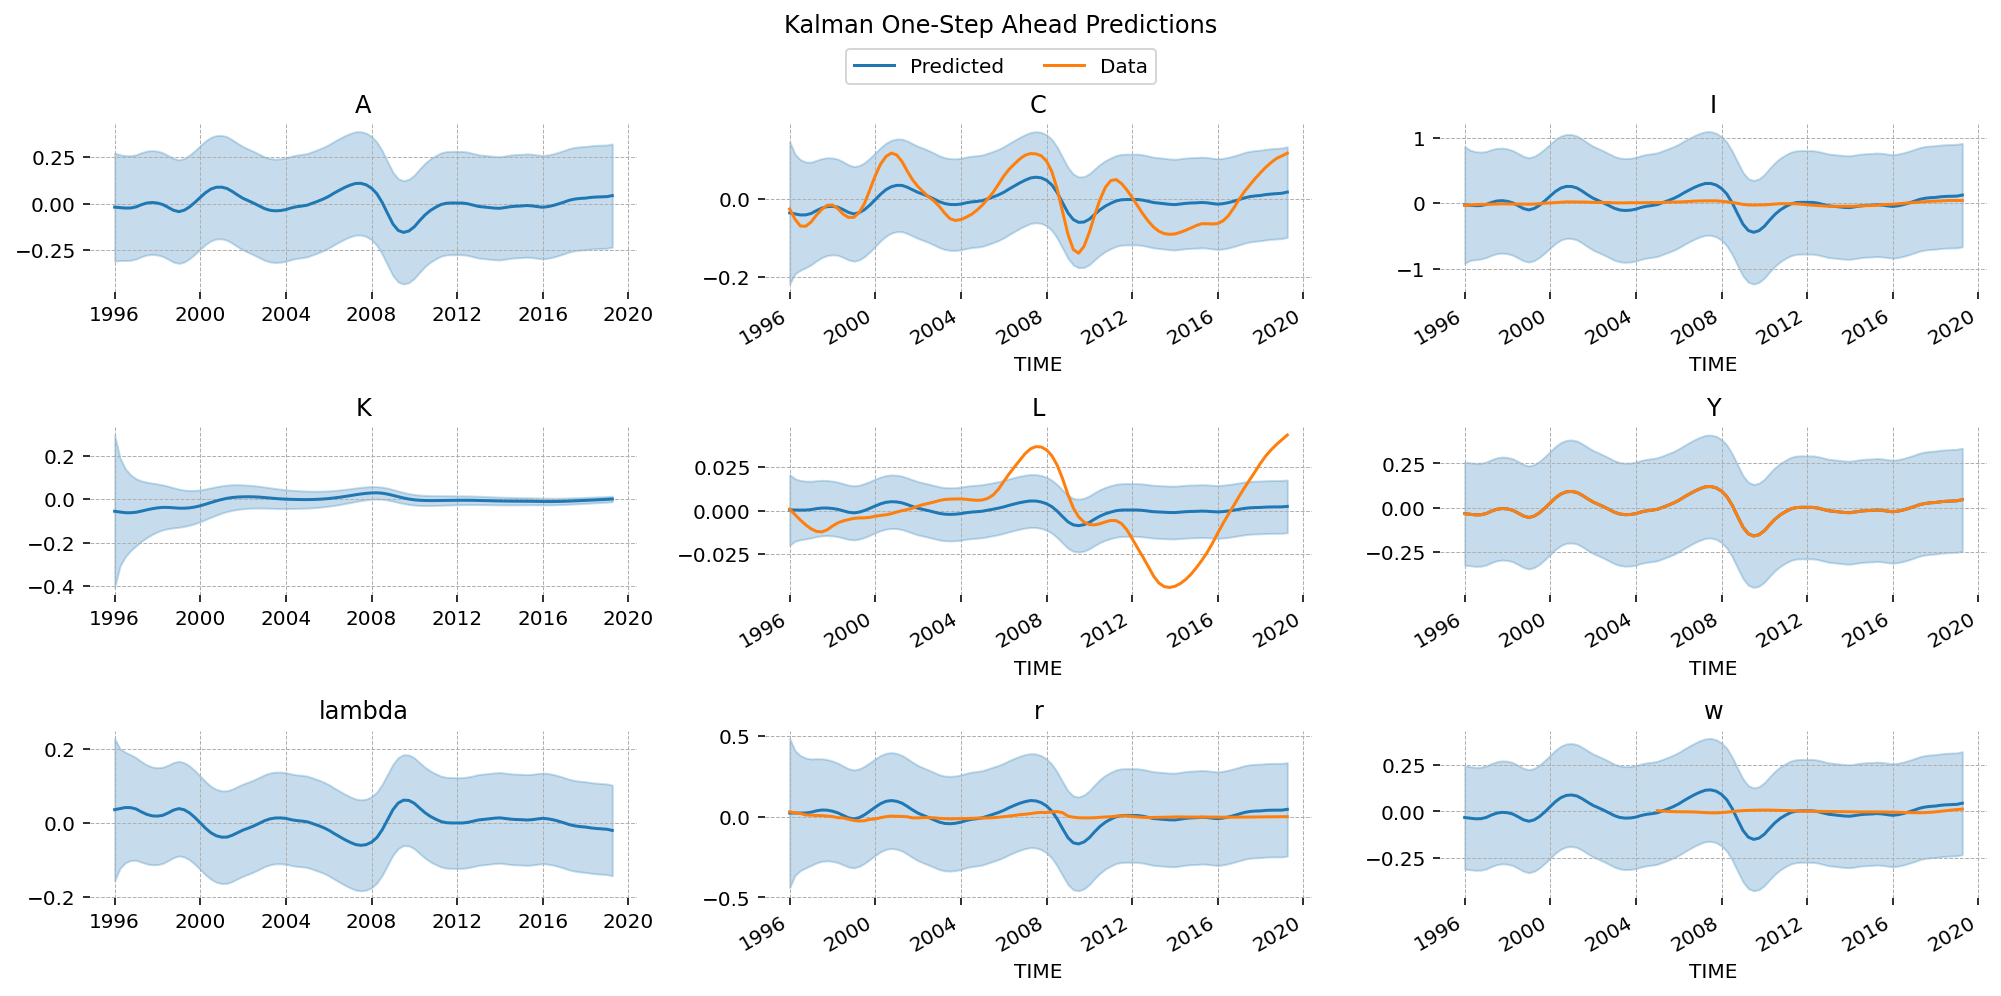

In [45]:
plot_sm_results(mle_res)

## Kalman Smoother output <a class="anchor" id="section_4_2"></a>

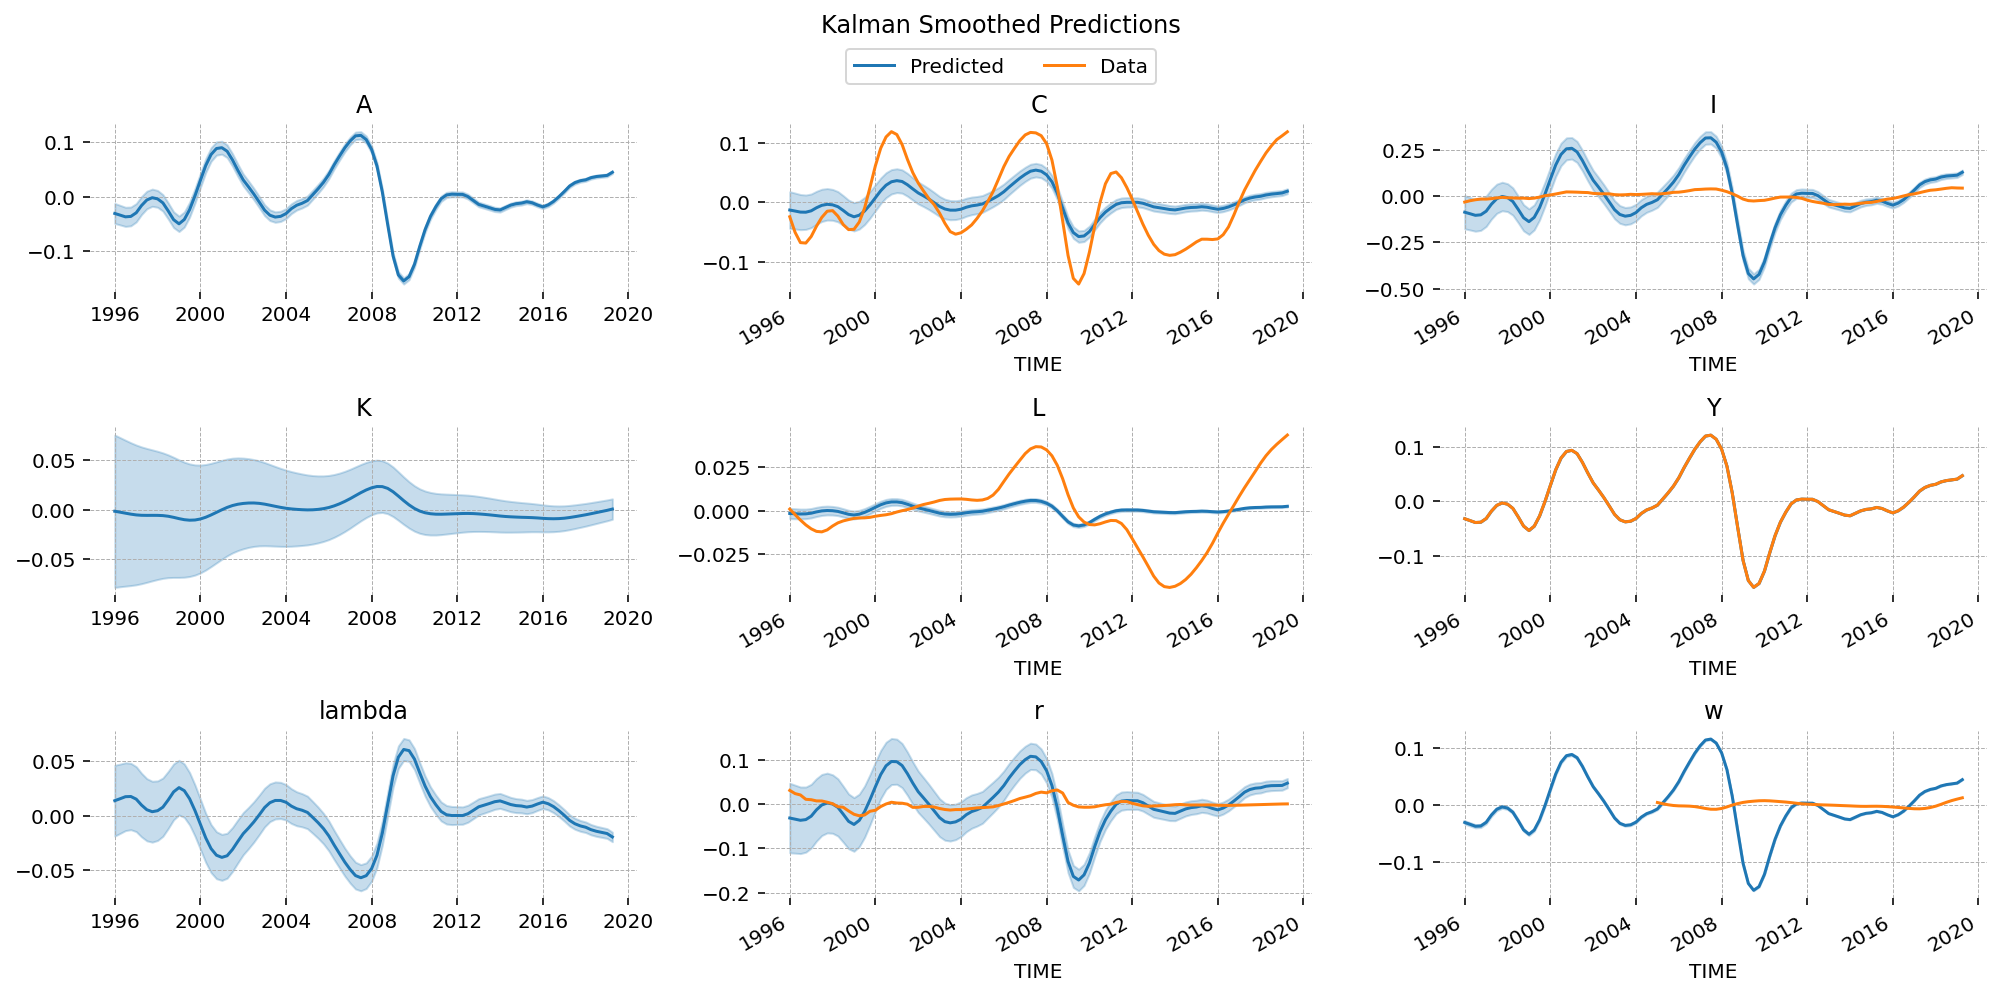

In [46]:
plot_sm_results(mle_res, 'smoothed')

## Impulse response <a class="anchor" id="section_4_3"></a>

In [47]:
irf_df = mle_res.impulse_responses(impulse=0, steps=1_000, orthogonalized=False)
irf_df.index = pd.MultiIndex.from_product([irf_df.index, ['epsilon_A']], names=['Time', 'Shocks'])
irf_df.columns.name = 'Variables'

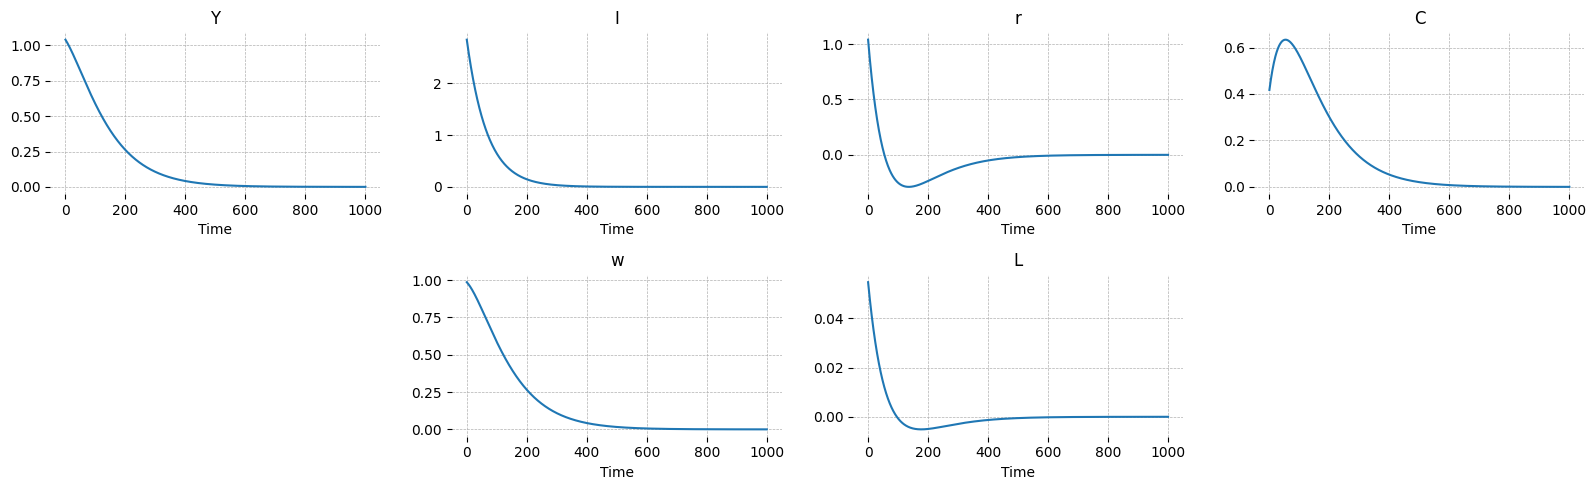

In [48]:
fig = gp.plot_irf(irf_df.T, shocks_to_plot='epsilon_A', figsize=(16,5))
plt.show()

### New Steady State

In [55]:
rbc.print_steady_state()

A_ss               1.000
C_ss               2.342
I_ss               0.809
K_ss              80.948
L_ss               0.996
Y_ss               3.151
lambda_ss          0.409
r_ss               0.010
w_ss               2.336


In [72]:
data.describe().round(3)

,Y,I,r,C,w,L
count,94.000,94.000,94.000,94.000,58.000,94.000
mean,75594.559,285724.392,0.025,72027.106,93.907,2200998.051
std,9357.328,16983.315,0.024,10155.783,6.826,70399.568
min,57724.877,245238.270,-0.003,45786.158,80.400,2067501.699
25%,67202.204,275716.580,0.002,66882.040,89.025,2140999.185
50%,75472.323,285518.963,0.021,73351.326,95.700,2210853.179
75%,82754.782,296556.459,0.040,80060.014,99.775,2242119.181
max,96854.356,323131.211,0.099,88778.789,103.100,2335576.895
